![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2F03+-+BigQuery+ML+%28BQML%29&file=BQML+Feature+Engineering+-+reusable+and+modular.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/03%20-%20BigQuery%20ML%20%28BQML%29/BQML%20Feature%20Engineering%20-%20reusable%20and%20modular.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2F03%2520-%2520BigQuery%2520ML%2520%2528BQML%2529%2FBQML%2520Feature%2520Engineering%2520-%2520reusable%2520and%2520modular.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/03%20-%20BigQuery%20ML%20%28BQML%29/BQML%20Feature%20Engineering%20-%20reusable%20and%20modular.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/03%20-%20BigQuery%20ML%20%28BQML%29/BQML%20Feature%20Engineering%20-%20reusable%20and%20modular.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# BigQuery ML (BQML) Feature Engineering - Reusable and Modular

This tutorial accompanies the blog post [Making BigQuery ML Feature Preprocessing Reusable and Modular]().

Transforming raw data into meaningful features = preprocessing.   The [`TRANSFORM` statement](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform) makes embedding feature engineering with BigQuery ML models easy.  This workflow expands on this concept with two new ways of working with feature engineering in BigQuery ML:
- Reusable preprocessing with [`ML.TRANSFORM` table function](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-transform)
- Modular preprocessing with [`TRANSFORM_ONLY` models](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-transform)

---
## Find & Replace Project ID

This workflow uses IPython Magics for readability and for making SQL queries easy to copy/paste to other editors, like the BigQuery console.  It is recommended to first do a find & replace of the project id used in this notebook with the one in your environment.  
- Replace all occurences of `statmike-mlops-349915` with the value of your project id.

---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/03%20-%20BigQuery%20ML%20(BQML)/BQML%20Feature%20Engineering%20-%20reusable%20and%20modular.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

## Installs (If Needed)

The clients packages may need installing in this environment. 

In [3]:
# tuples of (import name, install name)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'),
    ('google.cloud.bigquery', 'google-cloud-bigquery'),
    ('google.cloud.storage', 'google-cloud-storage'),
    ('bigframes', 'bigframes'),
    ('pandas', 'pandas')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [4]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

---
## Setup

Inputs

In [5]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [6]:
REGION = 'us-central1'

# specify a GCS Bucket
GCS_BUCKET = PROJECT_ID

# BigQuery Source Table
BQ_SOURCE_TABLE = 'bigquery-public-data.ml_datasets.penguins'

# BigQuery Environment Parameters
BQ_REGION = REGION[0:2] # use multi-region
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'bqml'
BQ_TABLE_PREFIX = 'feature-engineering'

Packages

In [7]:
from google.cloud import bigquery
from google.cloud import aiplatform
from google.cloud import storage
import bigframes.pandas as bf
import bigframes.ml as bfml
import pandas as pd

# load BigQuery IPython Magics (for Jupyter Notebooks)
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


Clients

In [8]:
# bigquery client
bq = bigquery.Client(project = PROJECT_ID)

# vertex ai client
aiplatform.init(project = PROJECT_ID, location = REGION)

# gcs client
gcs = storage.Client(project = PROJECT_ID)

# setup BigFrames API
bf.reset_session()
bf.options.bigquery.project = BQ_PROJECT
bf.options.bigquery.location = BQ_REGION
bf_session = bf.get_global_session()

---
## BigQuery Source Data

The source table is a BigQuery Public Dataset table.  The following cell uses the BigQuery IPython magic to retrieve 5 rows of the table for review.  This data is known as [Palmer Penguins](https://allisonhorst.github.io/palmerpenguins/) data: 

```
@Manual{,
  title = {palmerpenguins: Palmer Archipelago (Antarctica) penguin data},
  author = {Allison Marie Horst and Alison Presmanes Hill and Kristen B Gorman},
  year = {2020},
  note = {R package version 0.1.0},
  doi = {10.5281/zenodo.3960218},
  url = {https://allisonhorst.github.io/palmerpenguins/},
}
```


There are 334 observations of 4 numerical features (culman length, culmen depth, flipper length, body mass) and 2  categorical features (island, sex) that represent 3 species of penguins.

In [9]:
%%bigquery
SELECT *
FROM `bigquery-public-data.ml_datasets.penguins`
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie Penguin (Pygoscelis adeliae),Dream,36.6,18.4,184.0,3475.0,FEMALE
1,Adelie Penguin (Pygoscelis adeliae),Dream,39.8,19.1,184.0,4650.0,MALE
2,Adelie Penguin (Pygoscelis adeliae),Dream,40.9,18.9,184.0,3900.0,MALE
3,Chinstrap penguin (Pygoscelis antarctica),Dream,46.5,17.9,192.0,3500.0,FEMALE
4,Adelie Penguin (Pygoscelis adeliae),Dream,37.3,16.8,192.0,3000.0,FEMALE


Review the mean values of each measurement within `species`:

In [10]:
%%bigquery
SELECT species, count(*) as count,
    AVG(culmen_length_mm) as mean_culmen_length,
    AVG(culmen_depth_mm) as mean_culment_depth,
    AVG(flipper_length_mm) as mean_flipper_length,
    AVG(body_mass_g) as mean_body_mass
FROM `bigquery-public-data.ml_datasets.penguins`
GROUP BY species

Query is running:   0%|          |

Downloading:   0%|          |

,species,count,mean_culmen_length,mean_culment_depth,mean_flipper_length,mean_body_mass
0,Adelie Penguin (Pygoscelis adeliae),152,38.791391,18.346358,189.953642,3700.662252
1,Chinstrap penguin (Pygoscelis antarctica),68,48.833824,18.420588,195.823529,3733.088235
2,Gentoo penguin (Pygoscelis papua),124,47.504878,14.982114,217.186992,5076.016260


Review the mean values of each measurement within `species` and `island`:

In [11]:
%%bigquery
SELECT species, island, count(*) as count,
    AVG(culmen_length_mm) as mean_culmen_length,
    AVG(culmen_depth_mm) as mean_culment_depth,
    AVG(flipper_length_mm) as mean_flipper_length,
    AVG(body_mass_g) as mean_body_mass
FROM `bigquery-public-data.ml_datasets.penguins`
GROUP BY species, island

Query is running:   0%|          |

Downloading:   0%|          |

,species,island,count,mean_culmen_length,mean_culment_depth,mean_flipper_length,mean_body_mass
0,Adelie Penguin (Pygoscelis adeliae),Dream,56,38.501786,18.251786,189.732143,3688.392857
1,Chinstrap penguin (Pygoscelis antarctica),Dream,68,48.833824,18.420588,195.823529,3733.088235
2,Gentoo penguin (Pygoscelis papua),Biscoe,124,47.504878,14.982114,217.186992,5076.016260
3,Adelie Penguin (Pygoscelis adeliae),Biscoe,44,38.975000,18.370455,188.795455,3709.659091
4,Adelie Penguin (Pygoscelis adeliae),Torgersen,52,38.950980,18.429412,191.196078,3706.372549


Review the mean values of each measurment within `species` and `sex`:

In [12]:
%%bigquery
SELECT species, sex, count(*) as count,
    AVG(culmen_length_mm) as mean_culmen_length,
    AVG(culmen_depth_mm) as mean_culment_depth,
    AVG(flipper_length_mm) as mean_flipper_length,
    AVG(body_mass_g) as mean_body_mass
FROM `bigquery-public-data.ml_datasets.penguins`
GROUP BY species, sex

Query is running:   0%|          |

Downloading:   0%|          |

,species,sex,count,mean_culmen_length,mean_culment_depth,mean_flipper_length,mean_body_mass
0,Adelie Penguin (Pygoscelis adeliae),FEMALE,73,37.257534,17.621918,187.794521,3368.835616
1,Adelie Penguin (Pygoscelis adeliae),MALE,73,40.390411,19.072603,192.410959,4043.493151
2,Chinstrap penguin (Pygoscelis antarctica),FEMALE,34,46.573529,17.588235,191.735294,3527.205882
3,Chinstrap penguin (Pygoscelis antarctica),MALE,34,51.094118,19.252941,199.911765,3938.970588
4,Adelie Penguin (Pygoscelis adeliae),None,6,37.840000,18.320000,185.600000,3540.000000
5,Gentoo penguin (Pygoscelis papua),None,4,46.000000,14.166667,215.333333,4491.666667
6,Gentoo penguin (Pygoscelis papua),FEMALE,58,45.563793,14.237931,212.706897,4679.741379
7,Gentoo penguin (Pygoscelis papua),MALE,61,49.473770,15.718033,221.540984,5484.836066
8,Gentoo penguin (Pygoscelis papua),.,1,44.500000,15.700000,217.000000,4875.000000


Which observations have missing values?

In [13]:
%%bigquery
SELECT *
FROM `bigquery-public-data.ml_datasets.penguins`
WHERE sex IS NULL OR sex = '.'
    OR culmen_length_mm IS NULL
    OR culmen_depth_mm IS NULL
    OR flipper_length_mm IS NULL
    OR body_mass_g IS NULL

Query is running:   0%|          |

Downloading:   0%|          |

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie Penguin (Pygoscelis adeliae),Dream,37.5,18.9,179.0,2975.0,None
1,Gentoo penguin (Pygoscelis papua),Biscoe,NaN,NaN,NaN,NaN,None
2,Gentoo penguin (Pygoscelis papua),Biscoe,47.3,13.8,216.0,4725.0,None
3,Gentoo penguin (Pygoscelis papua),Biscoe,44.5,14.3,216.0,4100.0,None
4,Gentoo penguin (Pygoscelis papua),Biscoe,44.5,15.7,217.0,4875.0,.
5,Gentoo penguin (Pygoscelis papua),Biscoe,46.2,14.4,214.0,4650.0,None
6,Adelie Penguin (Pygoscelis adeliae),Torgersen,NaN,NaN,NaN,NaN,None
7,Adelie Penguin (Pygoscelis adeliae),Torgersen,34.1,18.1,193.0,3475.0,None
8,Adelie Penguin (Pygoscelis adeliae),Torgersen,37.8,17.1,186.0,3300.0,None
9,Adelie Penguin (Pygoscelis adeliae),Torgersen,37.8,17.3,180.0,3700.0,None


In [14]:
%bigquery_stats bigquery-public-data.ml_datasets.penguins

Getting table schema...: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]
Querying data in column 'sex': : 7it [00:04,  1.62it/s]              
Retrieve stats for 'sex': 100%|██████████| 7/7 [00:44<00:00,  6.37s/it]              


### Processing As Dataframes Using BigFrames API

It can be helpful to use the `.describe()` method from Pandas.  The [BigFrames](https://cloud.google.com/python/docs/reference/bigframes/latest) API allows you to work in Python with dataframe like objects while the execution remains inside of BigQuery.

In [15]:
df = bf.read_gbq(BQ_SOURCE_TABLE)

In [16]:
df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.0,342.0,342.0,342.0
mean,43.92193,17.15117,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.1,13.1,172.0,2700.0
25%,39.2,15.5,190.0,3550.0
50%,44.1,17.3,197.0,4000.0
75%,48.5,18.7,213.0,4750.0
max,59.6,21.5,231.0,6300.0


---
## BigQuery Setup

This workflow uses a BigQuery Public Dataset table (reviewed above).  This section creates (or links existing) dataset in the users BigQuery project.  This dataset is used to store the model object created below.

Create the dataset if missing:

In [9]:
ds = bigquery.Dataset(f"{BQ_PROJECT}.{BQ_DATASET}")
ds.location = BQ_REGION
ds = bq.create_dataset(dataset = ds, exists_ok = True)

Review dataset attributes:

In [10]:
ds.dataset_id

'bqml'

In [11]:
ds.project

'statmike-mlops-349915'

In [12]:
ds.full_dataset_id

'statmike-mlops-349915:bqml'

In [13]:
ds.path

'/projects/statmike-mlops-349915/datasets/bqml'

In [14]:
ds.location

'US'

### Add Train/Eval Splits To Source Data

Make a copy of the source data in the local project including a column `split` with values of 'TRAIN' and 'EVAL'.  The code below shows how to do stratified sampling for balance across the categorical variable `island` within each `species`.

> When using the [`CREATE MODEL` statement](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform) the method of data splitting can be specified with the `DATA_SPLIT_METHOD` option - see [boosted tree](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-boosted-tree#data_split_method) for example.  The default value is `AUTO_SPLIT` which would not split the training data for this example because it has fewer than 500 rows.  Specifying 'RANDOM' as the method will use the values of options `DATA_SPLIT_EVAL_FRACTION` and `DATA_SPLIT_TEST_FRACTION` to direct the data split.  In the example here the `CUSTOM` method is used and the splitting is done ahead of time with the SQL query that follows.  It does stratifed sampling to ensure balanced splits across both 'species' and 'island' values.

Use the Python Client for BigQuery to create the source table with `split` column.  This uses an formated string in Python to construct the query string using parameters.

In [23]:
query_job = bq.query(
    f'''
    CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}-source` AS
        SELECT * EXCEPT(seq, count),
            CASE
                WHEN seq <= CEIL(.1 * count) THEN 'EVAL'
                WHEN species IS NULL THEN 'EVAL'
                ELSE 'TRAIN'
            END AS split
        FROM (
            SELECT * EXCEPT(sex),
                CASE WHEN sex = '.' THEN NULL ELSE sex END AS sex,
                ROW_NUMBER() OVER (PARTITION BY species, island ORDER BY RAND()) as seq
            FROM `{BQ_SOURCE_TABLE}`
        )
        LEFT OUTER JOIN (
            SELECT species, island, COUNT(*) as count
            FROM `{BQ_SOURCE_TABLE}`
            GROUP BY species, island
        )
        USING(species, island)
    '''
)
query_job.result()

Print out the table name with full URI:

In [24]:
print(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}-source')

statmike-mlops-349915.bqml.feature-engineering-source


Review the TRAIN/EVAL split:

In [25]:
%%bigquery
SELECT species, island,
    COUNT(*) as count,
    100 * COUNTIF(split = 'TRAIN')/COUNT(*) AS TRAIN_PCT,
    100 * COUNTIF(split = 'EVAL')/COUNT(*) AS EVAL_PCT
FROM `statmike-mlops-349915.bqml.feature-engineering-source`
GROUP BY species, island

Query is running:   0%|          |

Downloading:   0%|          |

,species,island,count,TRAIN_PCT,EVAL_PCT
0,Adelie Penguin (Pygoscelis adeliae),Dream,56,89.285714,10.714286
1,Chinstrap penguin (Pygoscelis antarctica),Dream,68,89.705882,10.294118
2,Gentoo penguin (Pygoscelis papua),Biscoe,124,89.516129,10.483871
3,Adelie Penguin (Pygoscelis adeliae),Biscoe,44,88.636364,11.363636
4,Adelie Penguin (Pygoscelis adeliae),Torgersen,52,88.461538,11.538462


Which observations have missing values?  

In [26]:
%%bigquery
SELECT *
FROM `statmike-mlops-349915.bqml.feature-engineering-source`
WHERE sex IS NULL OR sex = '.'
    OR culmen_length_mm IS NULL
    OR culmen_depth_mm IS NULL
    OR flipper_length_mm IS NULL
    OR body_mass_g IS NULL

Query is running:   0%|          |

Downloading:   0%|          |

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,split
0,Adelie Penguin (Pygoscelis adeliae),Dream,37.5,18.9,179.0,2975.0,None,TRAIN
1,Gentoo penguin (Pygoscelis papua),Biscoe,NaN,NaN,NaN,NaN,None,TRAIN
2,Gentoo penguin (Pygoscelis papua),Biscoe,47.3,13.8,216.0,4725.0,None,TRAIN
3,Gentoo penguin (Pygoscelis papua),Biscoe,44.5,14.3,216.0,4100.0,None,TRAIN
4,Gentoo penguin (Pygoscelis papua),Biscoe,44.5,15.7,217.0,4875.0,None,TRAIN
5,Gentoo penguin (Pygoscelis papua),Biscoe,46.2,14.4,214.0,4650.0,None,TRAIN
6,Adelie Penguin (Pygoscelis adeliae),Torgersen,NaN,NaN,NaN,NaN,None,TRAIN
7,Adelie Penguin (Pygoscelis adeliae),Torgersen,34.1,18.1,193.0,3475.0,None,TRAIN
8,Adelie Penguin (Pygoscelis adeliae),Torgersen,37.8,17.1,186.0,3300.0,None,TRAIN
9,Adelie Penguin (Pygoscelis adeliae),Torgersen,37.8,17.3,180.0,3700.0,None,TRAIN


---
## Embedded Preprocessing

### Create Model Using `TRANSFORM` statement

Using the [`TRANSFORM` clause](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform), you can specify the desired preprocessing of columns into features.  In the case of this data there are several desired preprocessing steps based on the data review above:
- impute missing values with [`ML.IMPUTER`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-imputer)
- scale the `body_mass_g` column with [`ML.ROBUST_SCALER`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-robust-scaler)
- scale the other numerical columns with [`ML.STANDARD_SCALER`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-standard-scaler)

The model specification below does the data imputation in the input query and the scaling is embedded in the model with a `TRANSFORM` clause.

In [35]:
%%bigquery
CREATE OR REPLACE MODEL `statmike-mlops-349915.bqml.embedded_preprocessing`
    TRANSFORM(
        species, sex, island, split,
        ML.ROBUST_SCALER(body_mass_g) OVER() AS body_mass_g,
        ML.STANDARD_SCALER(culmen_length_mm) OVER() AS culmen_length_mm,
        ML.STANDARD_SCALER(culmen_depth_mm) OVER() AS culmen_depth_mm,
        ML.STANDARD_SCALER(flipper_length_mm) OVER() AS flipper_length_mm
    )
    OPTIONS(
        model_type = 'BOOSTED_TREE_CLASSIFIER',
        input_label_cols = ['species'],
        data_split_method = 'CUSTOM',
        data_split_col = 'split',
        model_registry = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = 'bqml_embedded_preprocessing'
    )
AS
SELECT species, island,
    CASE WHEN split = 'TRAIN' THEN FALSE ELSE TRUE END AS split,
    ML.IMPUTER(sex, 'most_frequent') OVER() AS sex,
    ML.IMPUTER(body_mass_g, 'median') OVER() AS body_mass_g,
    ML.IMPUTER(culmen_length_mm, 'mean') OVER() AS culmen_length_mm,
    ML.IMPUTER(culmen_depth_mm, 'mean') OVER() AS culmen_depth_mm,
    ML.IMPUTER(flipper_length_mm, 'mean') OVER() AS flipper_length_mm, 
FROM `statmike-mlops-349915.bqml.feature-engineering-source`

Query is running:   0%|          |

""


The feature information for the model can be reviewed with [ML.FEATURE_INFO](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-feature).  This shows summary statistics pre-transformation.  Notice that the `null_count` is 0 for all features because the [`ML.IMPUTER`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-imputer) functions filled in the missing values as instructed on the query statement.

In [27]:
%%bigquery
SELECT *
FROM ML.FEATURE_INFO(MODEL `statmike-mlops-349915.bqml.embedded_preprocessing`)

Query is running:   0%|          |

Downloading:   0%|          |

,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,culmen_length_mm,32.1,58.0,43.835322,44.4,5.378822,<NA>,0,<NA>
1,body_mass_g,2700.0,6300.0,4201.710098,4000.0,801.896704,<NA>,0,<NA>
2,flipper_length_mm,172.0,231.0,200.732347,197.0,14.054983,<NA>,0,<NA>
3,island,NaN,NaN,NaN,NaN,NaN,3,0,<NA>
4,culmen_depth_mm,13.1,21.5,17.100333,17.3,1.936125,<NA>,0,<NA>
5,sex,NaN,NaN,NaN,NaN,NaN,2,0,<NA>


The [`ML.EVALUATE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-evaluate) function can be used to review the evaluation metrics, here for both splits combined.  Notice that the imputation with [`ML.IMPUTER`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-imputer) function needs to be repeated because it was not embedded in the model above.

In [28]:
%%bigquery
WITH
    imputed AS (
        SELECT species, island, split,
            ML.IMPUTER(sex, 'most_frequent') OVER() AS sex,
            ML.IMPUTER(body_mass_g, 'median') OVER() AS body_mass_g,
            ML.IMPUTER(culmen_length_mm, 'mean') OVER() AS culmen_length_mm,
            ML.IMPUTER(culmen_depth_mm, 'mean') OVER() AS culmen_depth_mm,
            ML.IMPUTER(flipper_length_mm, 'mean') OVER() AS flipper_length_mm, 
        FROM `statmike-mlops-349915.bqml.feature-engineering-source`  
    )
SELECT *
FROM ML.EVALUATE(
    MODEL `statmike-mlops-349915.bqml.embedded_preprocessing`,
    (SELECT * FROM imputed)
)

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,1.0,1.0,1.0,1.0,0.012105,1.0


---
## Reusable Preprocessing

With the [`ML.TRANSFORM`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-transform) function you can transform the results of a query statement using the transformation of a previously created model.  That makes any models `TRANSFORM` statement completely reusuable.  This is helpful because the transform statement also remembers values that were calculated when they were created - like the mean and standard-deviation used with [`ML.STANDARD_SCALER`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-standard-scaler).

### Using ML.TRANSFORM

First, a sample of raw data:

In [29]:
%%bigquery
SELECT *
FROM `statmike-mlops-349915.bqml.feature-engineering-source`
WHERE sex IS NULL AND island = 'Biscoe'

Query is running:   0%|          |

Downloading:   0%|          |

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,split
0,Gentoo penguin (Pygoscelis papua),Biscoe,NaN,NaN,NaN,NaN,None,TRAIN
1,Gentoo penguin (Pygoscelis papua),Biscoe,47.3,13.8,216.0,4725.0,None,TRAIN
2,Gentoo penguin (Pygoscelis papua),Biscoe,44.5,14.3,216.0,4100.0,None,TRAIN
3,Gentoo penguin (Pygoscelis papua),Biscoe,44.5,15.7,217.0,4875.0,None,TRAIN
4,Gentoo penguin (Pygoscelis papua),Biscoe,46.2,14.4,214.0,4650.0,None,TRAIN


Next, the same raw sample processed with imputed missing values first:

In [30]:
%%bigquery
WITH
    imputed AS (
        SELECT species, split, island,
            CASE WHEN sex IS NULL THEN TRUE ELSE FALSE END AS sex_null,
            ML.IMPUTER(sex, 'most_frequent') OVER() AS sex,
            ML.IMPUTER(body_mass_g, 'median') OVER() AS body_mass_g,
            ML.IMPUTER(culmen_length_mm, 'mean') OVER() AS culmen_length_mm,
            ML.IMPUTER(culmen_depth_mm, 'mean') OVER() AS culmen_depth_mm,
            ML.IMPUTER(flipper_length_mm, 'mean') OVER() AS flipper_length_mm, 
        FROM `statmike-mlops-349915.bqml.feature-engineering-source`  
    )
SELECT *
FROM imputed
WHERE sex IS NULL AND island = 'Biscoe'   

Query is running:   0%|          |

Downloading: |          |

,species,split,island,sex_null,sex,body_mass_g,culmen_length_mm,culmen_depth_mm,flipper_length_mm


Now, the raw sample with imputed values and then processed with the transformation from the model created above using `ML.TRANSFORM` to recall the reusable transformations:

In [31]:
%%bigquery
WITH
    imputed AS (
        SELECT species, split, island,
            CASE WHEN sex IS NULL THEN TRUE ELSE FALSE END AS sex_null,
            ML.IMPUTER(sex, 'most_frequent') OVER() AS sex,
            ML.IMPUTER(body_mass_g, 'median') OVER() AS body_mass_g,
            ML.IMPUTER(culmen_length_mm, 'mean') OVER() AS culmen_length_mm,
            ML.IMPUTER(culmen_depth_mm, 'mean') OVER() AS culmen_depth_mm,
            ML.IMPUTER(flipper_length_mm, 'mean') OVER() AS flipper_length_mm, 
        FROM `statmike-mlops-349915.bqml.feature-engineering-source`  
    )
SELECT *
FROM ML.TRANSFORM(
    MODEL `statmike-mlops-349915.bqml.embedded_preprocessing`,
    (SELECT *
     FROM imputed
     WHERE sex_null AND island = 'Biscoe'
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

,sex,island,body_mass_g,culmen_length_mm,culmen_depth_mm,flipper_length_mm,species,split,sex_null
0,MALE,Biscoe,0.500000,0.440350,-1.396969,0.945546,Gentoo penguin (Pygoscelis papua),TRAIN,True
1,MALE,Biscoe,0.000000,0.016132,0.026317,0.013056,Gentoo penguin (Pygoscelis papua),TRAIN,True
2,MALE,Biscoe,0.041667,0.123779,-1.448703,1.088077,Gentoo penguin (Pygoscelis papua),TRAIN,True
3,MALE,Biscoe,0.687500,0.123779,-0.724429,1.159342,Gentoo penguin (Pygoscelis papua),TRAIN,True
4,MALE,Biscoe,0.562500,0.645190,-1.707373,1.088077,Gentoo penguin (Pygoscelis papua),TRAIN,True


---
## Modular Preprocessing

What if you want to take adavantage of the `TRANSFORM` clauses results repeatedly across many models and other parts of your workflow?  Also, what if you want to apply multiple `TRANSFORM` clauses in sequence: like imputation then scaling? A great option is [building a model with only transformations using the `model_type = 'TRANSFORM_ONLY'`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-transform) as follows:

### Create A `TRANSFORM_ONLY` Model - For Imputation

In [32]:
%%bigquery
CREATE OR REPLACE MODEL `statmike-mlops-349915.bqml.modular_preprocessing_impute`
    TRANSFORM(
        ML.IMPUTER(sex, 'most_frequent') OVER() AS sex,
        ML.IMPUTER(body_mass_g, 'median') OVER() AS body_mass_g,
        ML.IMPUTER(culmen_length_mm, 'mean') OVER() AS culmen_length_mm,
        ML.IMPUTER(culmen_depth_mm, 'mean') OVER() AS culmen_depth_mm,
        ML.IMPUTER(flipper_length_mm, 'mean') OVER() AS flipper_length_mm
    )
    OPTIONS(
        model_type = 'TRANSFORM_ONLY',
        model_registry = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = 'bqml_modular_preprocessing_impute'
    )
AS
SELECT * 
FROM `statmike-mlops-349915.bqml.feature-engineering-source`
WHERE split = 'TRAIN'

Query is running:   0%|          |

""


Now apply the `TRANSFORM_ONLY` model using `ML.TRANSFORM`:

In [33]:
%%bigquery
SELECT *
FROM ML.TRANSFORM(
    MODEL `statmike-mlops-349915.bqml.modular_preprocessing_impute`,
    (SELECT *
        FROM `statmike-mlops-349915.bqml.feature-engineering-source`
        WHERE sex IS NULL and island = 'Biscoe')
)

Query is running:   0%|          |

Downloading:   0%|          |

,sex,body_mass_g,culmen_length_mm,culmen_depth_mm,flipper_length_mm,species,island,split
0,MALE,4050.0,43.9489,17.1557,200.961,Gentoo penguin (Pygoscelis papua),Biscoe,TRAIN
1,MALE,4725.0,47.3000,13.8000,216.000,Gentoo penguin (Pygoscelis papua),Biscoe,TRAIN
2,MALE,4100.0,44.5000,14.3000,216.000,Gentoo penguin (Pygoscelis papua),Biscoe,TRAIN
3,MALE,4875.0,44.5000,15.7000,217.000,Gentoo penguin (Pygoscelis papua),Biscoe,TRAIN
4,MALE,4650.0,46.2000,14.4000,214.000,Gentoo penguin (Pygoscelis papua),Biscoe,TRAIN


### Create A `TRANSFORM_ONLY` Model - For Scaling

In [34]:
%%bigquery
CREATE OR REPLACE MODEL `statmike-mlops-349915.bqml.modular_preprocessing_scale`
    TRANSFORM(
        ML.ROBUST_SCALER(body_mass_g) OVER() AS body_mass_g,
        ML.STANDARD_SCALER(culmen_length_mm) OVER() AS culmen_length_mm,
        ML.STANDARD_SCALER(culmen_depth_mm) OVER() AS culmen_depth_mm,
        ML.STANDARD_SCALER(flipper_length_mm) OVER() AS flipper_length_mm
    )
    OPTIONS(
        model_type = 'TRANSFORM_ONLY',
        model_registry = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = 'bqml_modular_preprocessing_scale'
)
AS
SELECT * 
FROM `statmike-mlops-349915.bqml.feature-engineering-source`
WHERE split = 'TRAIN'

Query is running:   0%|          |

""


Now apply the `TRANSFORM_ONLY` model using `ML.TRANSFORM`:

In [35]:
%%bigquery
SELECT *
FROM ML.TRANSFORM(
    MODEL `statmike-mlops-349915.bqml.modular_preprocessing_scale`,
    (SELECT *
        FROM `statmike-mlops-349915.bqml.feature-engineering-source`
        WHERE sex IS NULL and island = 'Biscoe')
)

Query is running:   0%|          |

Downloading:   0%|          |

,body_mass_g,culmen_length_mm,culmen_depth_mm,flipper_length_mm,species,island,sex,split
0,NaN,NaN,NaN,NaN,Gentoo penguin (Pygoscelis papua),Biscoe,None,TRAIN
1,0.562500,0.625818,-1.678211,1.080419,Gentoo penguin (Pygoscelis papua),Biscoe,None,TRAIN
2,0.041667,0.102918,-1.428157,1.080419,Gentoo penguin (Pygoscelis papua),Biscoe,None,TRAIN
3,0.687500,0.102918,-0.728007,1.152260,Gentoo penguin (Pygoscelis papua),Biscoe,None,TRAIN
4,0.500000,0.420393,-1.378146,0.936737,Gentoo penguin (Pygoscelis papua),Biscoe,None,TRAIN


## Feature Pipeline: With Multiple `TRANSFORM_ONLY` Models

Use BigQuery [CTEs (WITH Clause)](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax#with_clause) for modular pipeline definition.

In [36]:
%%bigquery
WITH
    raw AS (
        SELECT *
        FROM `statmike-mlops-349915.bqml.feature-engineering-source`
        WHERE sex IS NULL and island = 'Biscoe'
    ),
    impute AS (
        SELECT *
        FROM ML.TRANSFORM(
            MODEL `statmike-mlops-349915.bqml.modular_preprocessing_impute`,
            (SELECT * FROM raw)
        )
    ),
    scale AS (
        SELECT *
        FROM ML.TRANSFORM(
            MODEL `statmike-mlops-349915.bqml.modular_preprocessing_scale`,
            (SELECT * FROM impute)
        )
    )
SELECT *
FROM scale

Query is running:   0%|          |

Downloading:   0%|          |

,body_mass_g,culmen_length_mm,culmen_depth_mm,flipper_length_mm,sex,species,island,split
0,0.000000,0.000000,0.000000,0.000000,MALE,Gentoo penguin (Pygoscelis papua),Biscoe,TRAIN
1,0.562500,0.625818,-1.678211,1.080419,MALE,Gentoo penguin (Pygoscelis papua),Biscoe,TRAIN
2,0.041667,0.102918,-1.428157,1.080419,MALE,Gentoo penguin (Pygoscelis papua),Biscoe,TRAIN
3,0.687500,0.102918,-0.728007,1.152260,MALE,Gentoo penguin (Pygoscelis papua),Biscoe,TRAIN
4,0.500000,0.420393,-1.378146,0.936737,MALE,Gentoo penguin (Pygoscelis papua),Biscoe,TRAIN


This approach allows increased modularity with ease, so there can actually be feature specific transform like what might be accomplished with a feature store.  This section create a TRANSFORM_ONLY model for each feature:

In [15]:
%%bigquery
CREATE OR REPLACE MODEL `statmike-mlops-349915.bqml.modular_preprocessing_scale_body_mass_g`
    TRANSFORM(
        ML.ROBUST_SCALER(body_mass_g) OVER() AS body_mass_g
    )
    OPTIONS(model_type = 'TRANSFORM_ONLY')
AS
SELECT * 
FROM `statmike-mlops-349915.bqml.feature-engineering-source`
WHERE split = 'TRAIN'

Query is running:   0%|          |

""


In [16]:
%%bigquery
CREATE OR REPLACE MODEL `statmike-mlops-349915.bqml.modular_preprocessing_scale_culmen_length_mm`
    TRANSFORM(
        ML.STANDARD_SCALER(culmen_length_mm) OVER() AS culmen_length_mm
    )
    OPTIONS(model_type = 'TRANSFORM_ONLY')
AS
SELECT * 
FROM `statmike-mlops-349915.bqml.feature-engineering-source`
WHERE split = 'TRAIN'

Query is running:   0%|          |

""


In [17]:
%%bigquery
CREATE OR REPLACE MODEL `statmike-mlops-349915.bqml.modular_preprocessing_scale_culmen_depth_mm`
    TRANSFORM(
        ML.STANDARD_SCALER(culmen_depth_mm) OVER() AS culmen_depth_mm
    )
    OPTIONS(model_type = 'TRANSFORM_ONLY')
AS
SELECT * 
FROM `statmike-mlops-349915.bqml.feature-engineering-source`
WHERE split = 'TRAIN'

Query is running:   0%|          |

""


In [18]:
%%bigquery
CREATE OR REPLACE MODEL `statmike-mlops-349915.bqml.modular_preprocessing_scale_flipper_length_mm`
    TRANSFORM(
        ML.STANDARD_SCALER(flipper_length_mm) OVER() AS flipper_length_mm
    )
    OPTIONS(model_type = 'TRANSFORM_ONLY')
AS
SELECT * 
FROM `statmike-mlops-349915.bqml.feature-engineering-source`
WHERE split = 'TRAIN'

Query is running:   0%|          |

""


### Feature Pipeline As A View

The feature pipeline can be made if more reusuable by using it in a [view](https://cloud.google.com/bigquery/docs/views):

In [22]:
%%bigquery
CREATE OR REPLACE VIEW `statmike-mlops-349915.bqml.feature-engineering-preprocessing` AS
WITH
    raw AS (
        SELECT *
        FROM `statmike-mlops-349915.bqml.feature-engineering-source`
    ),
    impute AS (
        SELECT *
        FROM ML.TRANSFORM(
            MODEL `statmike-mlops-349915.bqml.modular_preprocessing_impute`,
            (SELECT * FROM raw)
        )
    ),
    feature_1 AS (
        SELECT *
        FROM ML.TRANSFORM(
            MODEL `statmike-mlops-349915.bqml.modular_preprocessing_scale_body_mass_g`,
            (SELECT * FROM impute)
        )
    ),
    feature_2 AS (
        SELECT *
        FROM ML.TRANSFORM(
            MODEL `statmike-mlops-349915.bqml.modular_preprocessing_scale_culmen_length_mm`,
            (SELECT * FROM feature_1)
        )
    ),
    feature_3 AS (
        SELECT *
        FROM ML.TRANSFORM(
            MODEL `statmike-mlops-349915.bqml.modular_preprocessing_scale_culmen_depth_mm`,
            (SELECT * FROM feature_2)
        )
    ),
    feature_4 AS (
        SELECT *
        FROM ML.TRANSFORM(
            MODEL `statmike-mlops-349915.bqml.modular_preprocessing_scale_flipper_length_mm`,
            (SELECT * FROM feature_3)
        )
    )
SELECT *
FROM feature_4

Query is running:   0%|          |

""


In [23]:
%%bigquery
SELECT *
FROM `statmike-mlops-349915.bqml.feature-engineering-preprocessing`
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

,flipper_length_mm,culmen_depth_mm,culmen_length_mm,body_mass_g,sex,species,island,split
0,-1.218498,0.872338,-0.569382,-0.125000,MALE,Adelie Penguin (Pygoscelis adeliae),Dream,TRAIN
1,-1.218498,0.972359,-0.774807,0.500000,MALE,Adelie Penguin (Pygoscelis adeliae),Dream,TRAIN
2,-1.218498,0.622284,-1.372408,-0.479167,FEMALE,Adelie Penguin (Pygoscelis adeliae),Dream,TRAIN
3,-0.643768,-0.277910,0.551118,-1.125000,FEMALE,Chinstrap penguin (Pygoscelis antarctica),Dream,TRAIN
4,-0.643768,0.672295,-0.139857,0.041667,MALE,Adelie Penguin (Pygoscelis adeliae),Dream,TRAIN


### Create A Model Using `TRANSFORM_ONLY` Models As A Feature Pipeline

Using the feature pipeline built form BigQuery CTEs as above can be the input to a `CREATE MODEL` statement:

In [24]:
%%bigquery
CREATE OR REPLACE MODEL `statmike-mlops-349915.bqml.modular_preprocessing`
    OPTIONS(
        model_type = 'BOOSTED_TREE_CLASSIFIER',
        input_label_cols = ['species'],
        data_split_method = 'CUSTOM',
        data_split_col = 'split',
        model_registry = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = 'bqml_modular_preprocessing'
    )
AS
SELECT * EXCEPT(split),
    CASE WHEN split = 'TRAIN' THEN FALSE ELSE TRUE END AS split
FROM `statmike-mlops-349915.bqml.feature-engineering-preprocessing`

Query is running:   0%|          |

""


The feature information for the model can be reviewed with [ML.FEATURE_INFO](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-feature).  This shows summary statistics pre-transformation inside the model, but since the features were pre-processed using modular `TRANSFORM_ONLY` models, the input features are already imputed and scaled.

In [25]:
%%bigquery
SELECT *
FROM ML.FEATURE_INFO(MODEL `statmike-mlops-349915.bqml.modular_preprocessing`)

Query is running:   0%|          |

Downloading:   0%|          |

,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,flipper_length_mm,-2.080591,2.158036,-0.000025,-0.284563,0.998366,<NA>,0,<NA>
1,culmen_depth_mm,-2.028286,2.172617,0.000019,0.072166,0.998363,<NA>,0,<NA>
2,culmen_length_mm,-2.212783,2.624044,-0.000009,0.102918,0.998365,<NA>,0,<NA>
3,body_mass_g,-1.125000,1.875000,0.125407,0.000000,0.660268,<NA>,0,<NA>
4,sex,NaN,NaN,NaN,NaN,NaN,2,0,<NA>
5,island,NaN,NaN,NaN,NaN,NaN,3,0,<NA>


The [`ML.EVALUATE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-evaluate) function can be used to review the evaluation metrics, here for both splits combined.  Notice that the feature pipeline needs to be repeated because it is not embedded in the model in this case.

In [26]:
%%bigquery
SELECT *
FROM ML.EVALUATE(
    MODEL `statmike-mlops-349915.bqml.modular_preprocessing`,
    (SELECT * FROM `statmike-mlops-349915.bqml.feature-engineering-preprocessing`)
)

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.997821,0.995098,0.997093,0.996438,0.015599,1.0


---
## Review Models With Step-By-Step Processing

This section takes a single row of data and traces it through `TRANSFORM_ONLY` models as well as the predictive models created (trained) above.

### Example Row - Raw

Create an example row and include a missing value to showcase the imputation `TRANSFORM_ONLY` model.

In [51]:
raw_dict = dict(
    known_species = 'Adelie Penguin (Pygoscelis adeliae)',
    island = 'Dream',
    culmen_length_mm = None, # 40.9
    culmen_depth_mm = 18.9,
    flipper_length_mm = 184.0,
    body_mass_g = 3900.00,
    sex = 'MALE'
)
raw_dict

{'known_species': 'Adelie Penguin (Pygoscelis adeliae)',
 'island': 'Dream',
 'culmen_length_mm': None,
 'culmen_depth_mm': 18.9,
 'flipper_length_mm': 184.0,
 'body_mass_g': 3900.0,
 'sex': 'MALE'}

### Preprocessing - Imputation

In [56]:
%%bigquery impute_dict
WITH
    raw AS (
        SELECT
            'Adelie Penguin (Pygoscelis adeliae)' as species,
            'Dream' as island,
            Null as culmen_length_mm,
            18.9 as culmen_depth_mm,
            184.0 as flipper_length_mm,
            3900.00 as body_mass_g,
            'MALE' as sex
    )
SELECT *
FROM ML.TRANSFORM(
    MODEL `statmike-mlops-349915.bqml.modular_preprocessing_impute`,
    (SELECT * FROM raw)
)

Query is running:   0%|          |

Downloading:   0%|          |

In [57]:
impute_dict

,sex,body_mass_g,culmen_length_mm,culmen_depth_mm,flipper_length_mm,species,island
0,MALE,3900.0,43.8348,18.9,184.0,Adelie Penguin (Pygoscelis adeliae),Dream


In [58]:
impute_dict = impute_dict.to_dict(orient = 'records')[0]
impute_dict

{'sex': 'MALE',
 'body_mass_g': 3900.0,
 'culmen_length_mm': 43.8348,
 'culmen_depth_mm': 18.9,
 'flipper_length_mm': 184.0,
 'species': 'Adelie Penguin (Pygoscelis adeliae)',
 'island': 'Dream'}

### Preprocessing - Imputation and Scaling

In [59]:
%%bigquery scale_dict
WITH
    raw AS (
        SELECT
            'Adelie Penguin (Pygoscelis adeliae)' as species,
            'Dream' as island,
            Null as culmen_length_mm,
            18.9 as culmen_depth_mm,
            184.0 as flipper_length_mm,
            3900.00 as body_mass_g,
            'MALE' as sex
    ),
    impute AS (
        SELECT *
        FROM ML.TRANSFORM(
            MODEL `statmike-mlops-349915.bqml.modular_preprocessing_impute`,
            (SELECT * FROM raw)
        )
    )
SELECT *
FROM ML.TRANSFORM(
    MODEL `statmike-mlops-349915.bqml.modular_preprocessing_scale`,
    (SELECT * FROM impute)
)

Query is running:   0%|          |

Downloading:   0%|          |

In [60]:
scale_dict

,body_mass_g,culmen_length_mm,culmen_depth_mm,flipper_length_mm,sex,species,island
0,-0.083333,0.0,0.928175,-1.18845,MALE,Adelie Penguin (Pygoscelis adeliae),Dream


In [61]:
scale_dict = scale_dict.to_dict(orient = 'records')[0]
scale_dict

{'body_mass_g': -0.08333333333333333,
 'culmen_length_mm': 0.0,
 'culmen_depth_mm': 0.9281747443652044,
 'flipper_length_mm': -1.188450063929535,
 'sex': 'MALE',
 'species': 'Adelie Penguin (Pygoscelis adeliae)',
 'island': 'Dream'}

### Prediction With Embedded Preprocessing

The model created above with embedded preprocessing has the scaling transformation built-in.   Here the imputed data row is used with `ML.PREDICT` to request a prediction with the embedded preprocessing version of the model.

In [64]:
%%bigquery
WITH
    raw AS (
        SELECT
            'Adelie Penguin (Pygoscelis adeliae)' as species,
            'Dream' as island,
            Null as culmen_length_mm,
            18.9 as culmen_depth_mm,
            184.0 as flipper_length_mm,
            3900.00 as body_mass_g,
            'MALE' as sex
    ),
    impute AS (
        SELECT *
        FROM ML.TRANSFORM(
            MODEL `statmike-mlops-349915.bqml.modular_preprocessing_impute`,
            (SELECT * FROM raw)
        )
    )
SELECT *
FROM ML.PREDICT(
    MODEL `statmike-mlops-349915.bqml.embedded_preprocessing`,
    (SELECT * FROM impute)
)

Query is running:   0%|          |

Downloading:   0%|          |

,predicted_species,predicted_species_probs,sex,body_mass_g,culmen_length_mm,culmen_depth_mm,flipper_length_mm,species,island
0,Adelie Penguin (Pygoscelis adeliae),[{'label': 'Gentoo penguin (Pygoscelis papua)'...,MALE,3900.0,43.8348,18.9,184.0,Adelie Penguin (Pygoscelis adeliae),Dream


### Prediction With Modular Preprocessing

The modular preprocessing model did all the preprocessing prior to the model with `TRANSFORM_ONLY` models.  This example takes the row after it has been processed through imputation and scaling.

In [65]:
%%bigquery
WITH
    raw AS (
        SELECT
            'Adelie Penguin (Pygoscelis adeliae)' as species,
            'Dream' as island,
            Null as culmen_length_mm,
            18.9 as culmen_depth_mm,
            184.0 as flipper_length_mm,
            3900.00 as body_mass_g,
            'MALE' as sex
    ),
    impute AS (
        SELECT *
        FROM ML.TRANSFORM(
            MODEL `statmike-mlops-349915.bqml.modular_preprocessing_impute`,
            (SELECT * FROM raw)
        )
    ),
    scale AS (
        SELECT *
        FROM ML.TRANSFORM(
            MODEL `statmike-mlops-349915.bqml.modular_preprocessing_scale`,
            (SELECT * FROM impute)
        )
    )
SELECT *
FROM ML.PREDICT(
    MODEL `statmike-mlops-349915.bqml.modular_preprocessing`,
    (SELECT * FROM scale)
)

Query is running:   0%|          |

Downloading:   0%|          |

,predicted_species,predicted_species_probs,body_mass_g,culmen_length_mm,culmen_depth_mm,flipper_length_mm,sex,species,island
0,Adelie Penguin (Pygoscelis adeliae),[{'label': 'Gentoo penguin (Pygoscelis papua)'...,-0.083333,0.0,0.928175,-1.18845,MALE,Adelie Penguin (Pygoscelis adeliae),Dream


---
## Using Models With BigFrames API

The model with modular preprocessing can be used directly with the [BigFrames API](https://cloud.google.com/python/docs/reference/bigframes/latest) as long as the inputs are first processed with the imputation and scaling preprocessors.

In [66]:
model = bf.read_gbq_model(f'{BQ_PROJECT}.{BQ_DATASET}.modular_preprocessing')

In [67]:
scale_dict

{'body_mass_g': -0.08333333333333333,
 'culmen_length_mm': 0.0,
 'culmen_depth_mm': 0.9281747443652044,
 'flipper_length_mm': -1.188450063929535,
 'sex': 'MALE',
 'species': 'Adelie Penguin (Pygoscelis adeliae)',
 'island': 'Dream'}

In [68]:
test_df = pd.Series(scale_dict).to_frame().T
test_bf = bf.read_pandas(test_df)
test_bf.head()

,body_mass_g,culmen_length_mm,culmen_depth_mm,flipper_length_mm,sex,species,island
0,-0.083333,0.0,0.928175,-1.18845,MALE,Adelie Penguin (Pygoscelis adeliae),Dream


In [69]:
model.predict(test_bf)

,predicted_species
0,Adelie Penguin (Pygoscelis adeliae)


---
## Export To GCS For Complete Portability

Models trained in BigQuery ML with the `CREATE MODEL` statement can be [exported](https://cloud.google.com/bigquery/docs/exporting-models) for portability.  This even includes a preprocessing model with the `TRANSFORM` statement is used during model creation.

In [70]:
gcs.lookup_bucket(GCS_BUCKET)

<Bucket: statmike-mlops-349915>

In [71]:
%%bigquery
EXPORT MODEL `statmike-mlops-349915.bqml.embedded_preprocessing`
    OPTIONS(URI = 'gs://statmike-mlops-349915/bqml/feature-engineering/models/embedded_preprocessing');
EXPORT MODEL `statmike-mlops-349915.bqml.modular_preprocessing`
    OPTIONS(URI = 'gs://statmike-mlops-349915/bqml/feature-engineering/models/modular_preprocessing');
EXPORT MODEL `statmike-mlops-349915.bqml.modular_preprocessing_impute`
    OPTIONS(URI = 'gs://statmike-mlops-349915/bqml/feature-engineering/models/modular_preprocessing_impute');
EXPORT MODEL `statmike-mlops-349915.bqml.modular_preprocessing_scale`
    OPTIONS(URI = 'gs://statmike-mlops-349915/bqml/feature-engineering/models/modular_preprocessing_scale');

Query is running:   0%|          |

""


In [72]:
for blob in list(gcs.bucket(GCS_BUCKET).list_blobs(prefix = 'bqml/feature-engineering/')):
    print(blob.name)

bqml/feature-engineering/
bqml/feature-engineering/models/
bqml/feature-engineering/models/embedded_preprocessing/
bqml/feature-engineering/models/embedded_preprocessing/assets/0_categorical_label.txt
bqml/feature-engineering/models/embedded_preprocessing/assets/1_categorical_label.txt
bqml/feature-engineering/models/embedded_preprocessing/assets/model_metadata.json
bqml/feature-engineering/models/embedded_preprocessing/explanation_metadata.json
bqml/feature-engineering/models/embedded_preprocessing/main.py
bqml/feature-engineering/models/embedded_preprocessing/model.bst
bqml/feature-engineering/models/embedded_preprocessing/transform/
bqml/feature-engineering/models/embedded_preprocessing/transform/assets/
bqml/feature-engineering/models/embedded_preprocessing/transform/fingerprint.pb
bqml/feature-engineering/models/embedded_preprocessing/transform/saved_model.pb
bqml/feature-engineering/models/embedded_preprocessing/transform/variables/
bqml/feature-engineering/models/embedded_prepro

---
## Online Serving With Vertex AI

For online serving the export to GCS can be bypassed and instead [register the BigQuery ML model](https://cloud.google.com/bigquery/docs/create_vertex) directly to [Vertex AI Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction) using the training option `MODEL_REGISTRY = 'VERTEX_AI'`.  This was already included in model created above and the cells that follow us the Python SDK for Vertex AI to review the model registry and [deploy the models](https://cloud.google.com/vertex-ai/docs/general/deployment) to a Vertex AI Prediction Endpoint for online serving.

In [73]:
## vertex ai client
aiplatform.init(project = PROJECT_ID, location = REGION)

In [74]:
for model in aiplatform.Model.list():
    if model.name.startswith('bqml_modular'): print(model.name)
    if model.name.startswith('bqml_embedded'): print(model.name)

bqml_modular_preprocessing
bqml_modular_preprocessing_scale
bqml_modular_preprocessing_impute
bqml_embedded_preprocessing


In [75]:
vertex_model = aiplatform.Model(model_name = 'bqml_embedded_preprocessing')

In [76]:
endpoint = aiplatform.Endpoint.create(display_name = 'bqml_embedded_preprocessing')

Creating Endpoint
Create Endpoint backing LRO: projects/1026793852137/locations/us-central1/endpoints/1328405759423152128/operations/8441581267635404800
Endpoint created. Resource name: projects/1026793852137/locations/us-central1/endpoints/1328405759423152128
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/1026793852137/locations/us-central1/endpoints/1328405759423152128')


In [77]:
endpoint = vertex_model.deploy(endpoint = endpoint)

Deploying model to Endpoint : projects/1026793852137/locations/us-central1/endpoints/1328405759423152128
Using default machine_type: n1-standard-2
Deploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/1328405759423152128/operations/3032758115163439104
Endpoint model deployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/1328405759423152128


In [78]:
impute_dict

{'sex': 'MALE',
 'body_mass_g': 3900.0,
 'culmen_length_mm': 43.8348,
 'culmen_depth_mm': 18.9,
 'flipper_length_mm': 184.0,
 'species': 'Adelie Penguin (Pygoscelis adeliae)',
 'island': 'Dream'}

In [79]:
# remove the known value that the model will predict:
del impute_dict['species']

In [80]:
endpoint.predict(instances = [impute_dict]).predictions

[{'predicted_species': 'Adelie Penguin (Pygoscelis adeliae)',
  'species_probs': [0.03061437793076038,
   0.3899675905704498,
   0.5794180035591125],
  'species_values': ['Gentoo penguin (Pygoscelis papua)',
   'Chinstrap penguin (Pygoscelis antarctica)',
   'Adelie Penguin (Pygoscelis adeliae)']}]

---
## Review Objects in GCP Console: BigQuery Models, GCS Exports, Vertex AI Models, Vertex AI Endpoints

While the models above were created using SQL that ran in BigQuery via coding methods from this notebook, it is possible to also still review each object directly in the GCP console.  This section includes direct links to the object created above as well as screen captures of what the object look like.

### Console: BigQuery Models

In [81]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{BQ_PROJECT}!2s{BQ_DATASET}!3sembedded_preprocessing')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sbqml!3sembedded_preprocessing


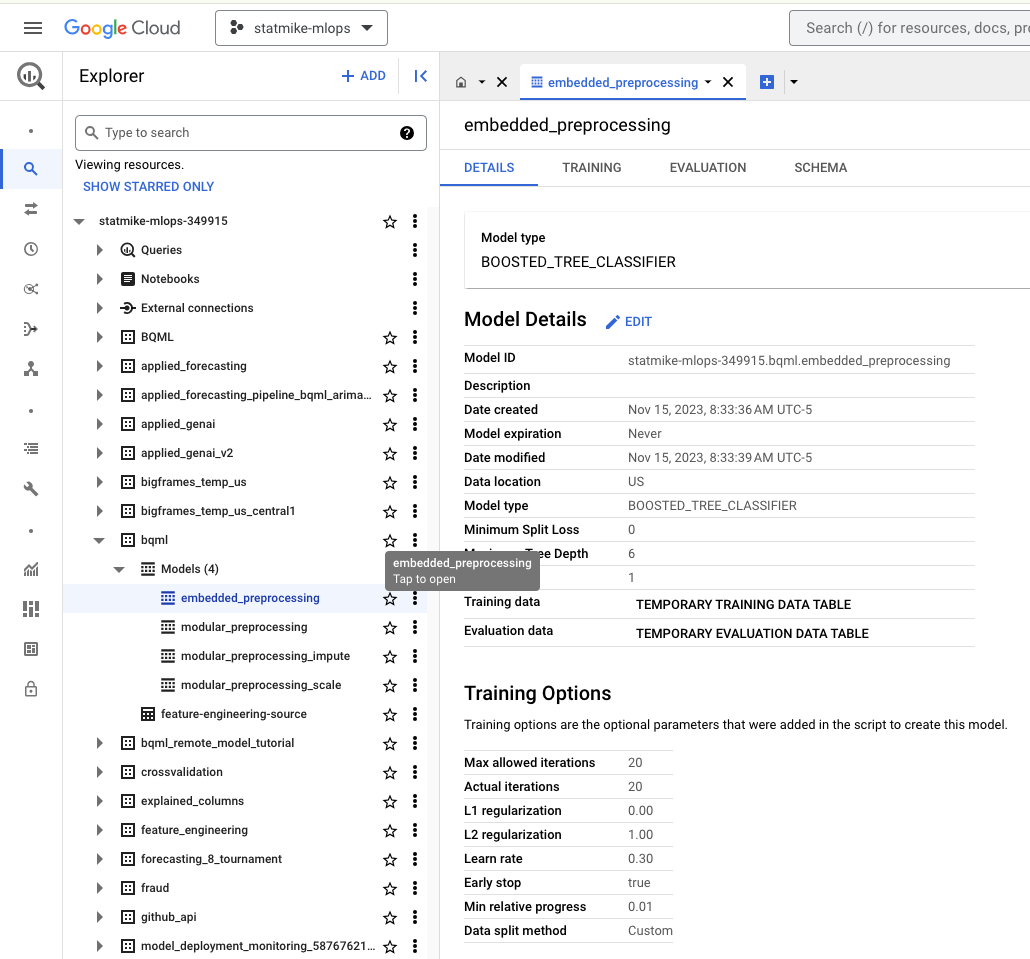

### Console: GCS Model Files

In [82]:
print(f'Direct link to exported model files in GCS:\nhttps://console.cloud.google.com/storage/browser/{GCS_BUCKET}/bqml/feature-engineering/models?project={PROJECT_ID}')

Direct link to exported model files in GCS:
https://console.cloud.google.com/storage/browser/statmike-mlops-349915/bqml/feature-engineering/models?project=statmike-mlops-349915


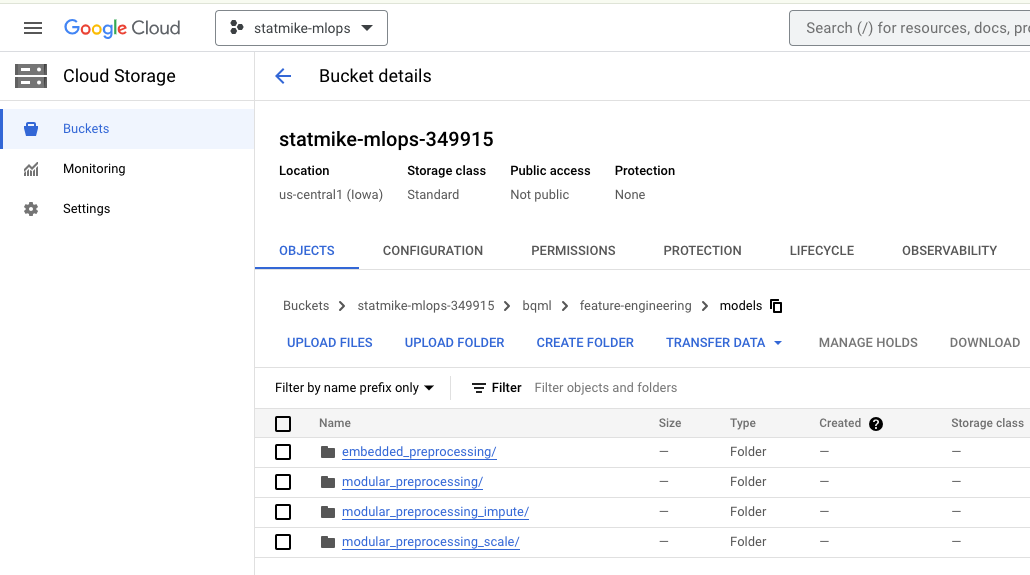

### Console: Vertex AI Model Registry

In [83]:
print(f'Direct link to Vertex AI Model Registry:\nhttps://console.cloud.google.com/vertex-ai/models?project={PROJECT_ID}')

Direct link to Vertex AI Model Registry:
https://console.cloud.google.com/vertex-ai/models?project=statmike-mlops-349915


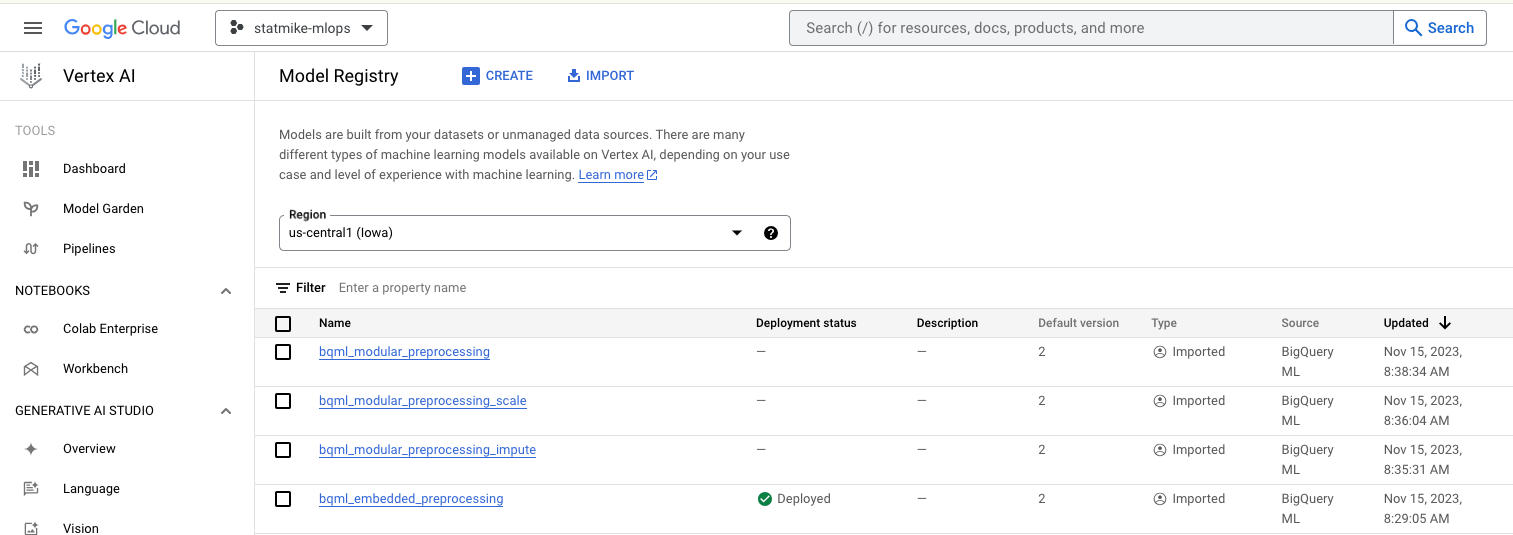

### Console: Vertex AI Endpoint

In [84]:
print(f'Direct link to Vertex AI Online Prediction Endpoints:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/endpoints/{endpoint.name}?project={PROJECT_ID}')

Direct link to Vertex AI Online Prediction Endpoints:
https://console.cloud.google.com/vertex-ai/locations/us-central1/endpoints/1328405759423152128?project=statmike-mlops-349915


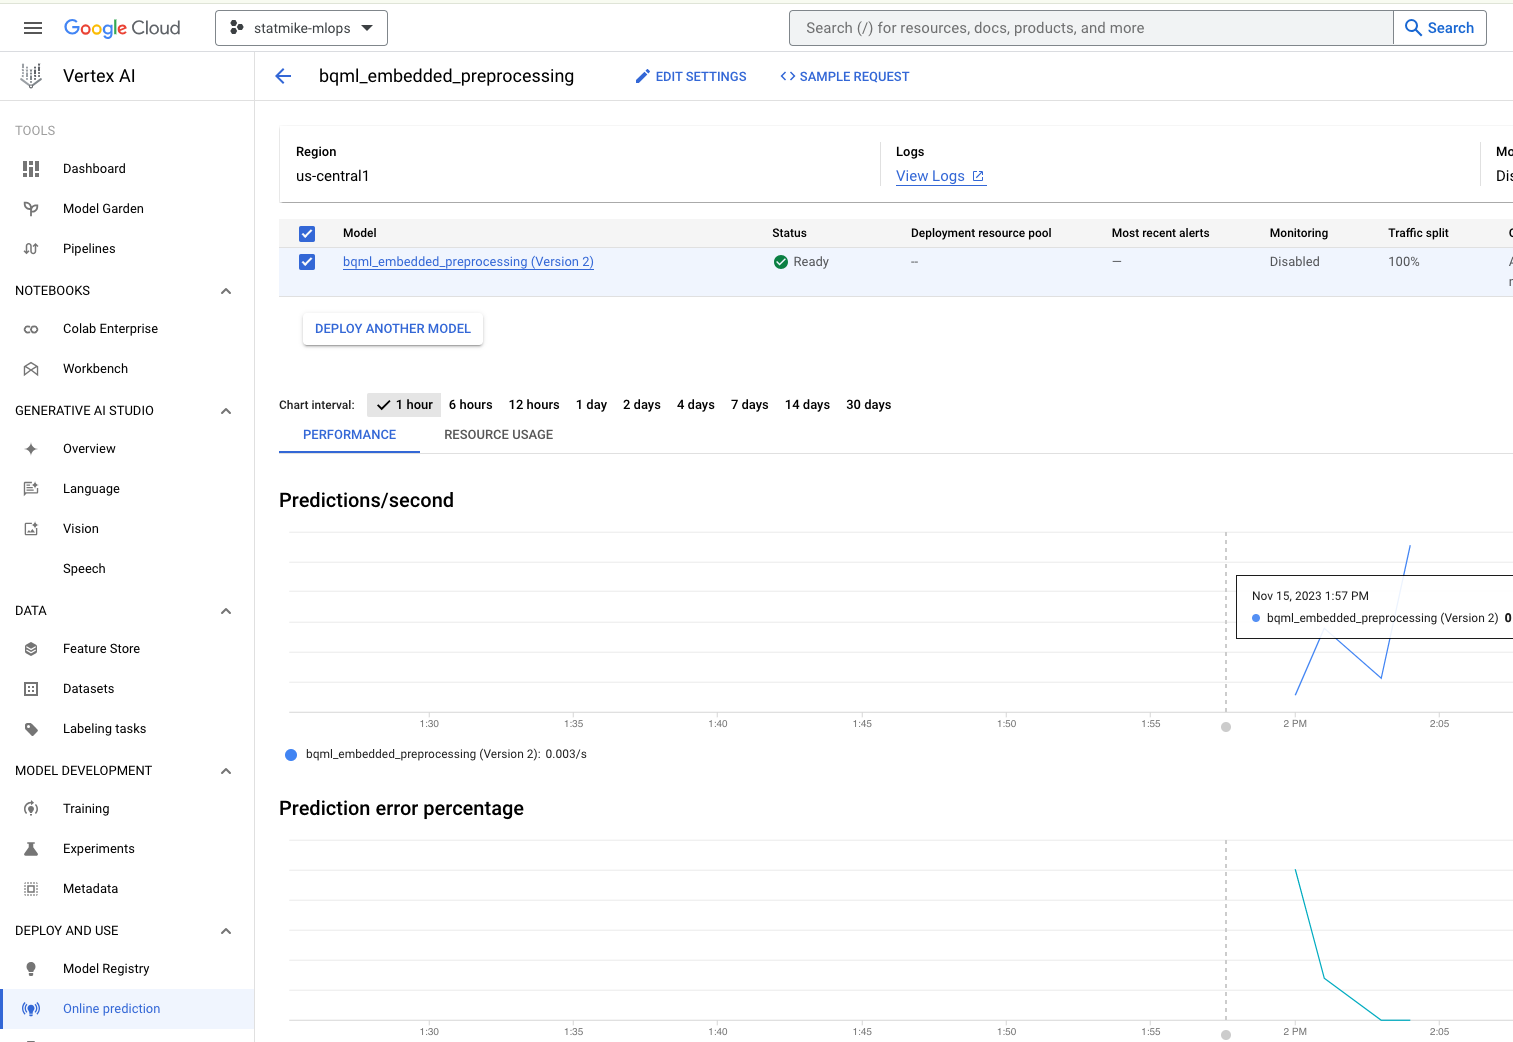

---
## Remove Resources Created In This Notebook

To avoid any ongoing cost form storage or compute (Vertex AI Prediction Endpoint), the follow cells are provided to remove all resources created in this notebook.

- Dataset In BigQuery
- Model Objects In BigQuery
- Model Exports in GCS
- Endpoints In Vertex AI

In [133]:
# to remove resources change this flag to True:
remove = False

In [134]:
# remove Vertex AI Online Prediction Endpoint
if remove:
    endpoint.delete(force = True)

In [135]:
# delete models created in BigQuery with BQML - note this also removes them from Vertex AI Model Registry
if remove:
    for model in list(bq.list_models(dataset = ds)):
        if model.model_id in ['embedded_preprocessing', 'modular_preprocessing_impute', 'modular_preprocessing_scale', 'modular_preprocessing']:
            print('deleting model: ', model.model_id)
            bq.delete_model(model)

In [136]:
# delete BigQuery table(s) created above
if remove:
    bq.delete_table(f'{BQ_PROJECT}.{BQ_DATASET}.feature-engineering-source')

In [137]:
# delete BigQuery dataset - fails if other content was in the dataset than what this notebook created
if remove:
    bq.delete_dataset(dataset = ds, delete_contents = False)

In [138]:
# delete model files exported to GCS
if remove:
    bucket = gcs.bucket(GCS_BUCKET)
    bucket.delete_blobs(blobs = list(bucket.list_blobs(prefix = 'bqml/feature-engineering/')))